# Part 2: Accessing International Debt Statistics (IDS) through World Bank API
### *guide in python 3*

Date: 05/22/2019 <br>
[Data source](https://datacatalog.worldbank.org/dataset/international-debt-statistics)<br>
[Developer Information](https://datahelpdesk.worldbank.org/knowledgebase/topics/125589-developer-information)

This is second part of a two-part series on accessing the International Debt Statistics (IDS) database through the World Bank Data API. In the first part (LINK NEEDED), we queried the World Bank Data API to retrieve indicator names and location codes. In this guide, we will use that information to explore the **regional trends of long-term external debt stocks** from the IDS database. The following code will show step-by-step how to:

1. Setup up your environment with the needed packages
2. Select your data specifications (as established in Part 1 (LINK NEEDED))
3. Use the World Bank API call to return the specified data
4. Explore the data through basic descriptive analysis // create a pretty chart.

## 1. Setup
To start, make sure you have the following packages installed on your machine. If you aren't familiar with how to install a Python package, visit each of the linked sites below for instructions.
- [pandas](https://pandas.pydata.org/): data analysis
- [numpy](https://www.numpy.org/): data analysis
- [datetime](https://wbdata.readthedocs.io/en/latest/#): parsing dates
- [wbdata](https://wbdata.readthedocs.io/en/latest/#): World Bank API wrapper
- [altair](https://altair-viz.github.io/getting_started/installation.html): data visualization

Then, open up your preferred mode of writing Python. This could be in a [Jupyter Notebook](https://jupyter.org/) using [Jupyter Lab](https://blog.jupyter.org/jupyterlab-is-ready-for-users-5a6f039b8906), using an IDE + command line, or just from the command line. Although the Altair chart works best in JupyterLab. Now follow the rest of the steps below to retreive and analyze the World Bank data.

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import datetime
import wbdata
import altair as alt
alt.renderers.enable('default') # for JupyterLab
# use alt.renderers.enable('notebook') if you're not using JupyterLab

RendererRegistry.enable('default')

## 2. Data Specifications
Now you can specify the the data that you want to explore using the following parameters:
- **Indicator(s)**: the indicator code for the data series
- **Location(s)**: countries, regions, income 
- **Time**: years

#### Indicator(s)
The World Bank's Data Catalog contains indicator codes for each data series. In this guide, we will be looking at "long-term external debt stock" from the IDS data. To find the indicator for the data in which you're interested, you can either explore the [World Bank data catalog](https://datacatalog.worldbank.org/) or use an API query (LINK NEEDED) as outlined in Part 1 of this series. The IDS indicators are also conveniently stored as a spreadsheet (LINK NEEDED) in this repo. 

In [2]:
# selecting the indictor
indicatorSelection = {"DT.DOD.DLXF.CD":"ExternalDebtStocks"}

The description that follows the code ("External debt stocks") is whatever you want to call it. To call more than one indicator, add more indicator names and descriptions to the dictionary.

#### Location(s)
To select a location by country, region, or income level you will need to know its 2 or 3 letter code. To figure out what this code is, you can either find it on the [WITS System site](https://wits.worldbank.org/wits/wits/witshelp/content/codes/country_codes.htm), use an API query as outlined in Part 1 of this series (LINK NEEDED), or use the convenient [location-codes spreadsheet](https://github.com/worldbank/debt-data/blob/master/location-codes.csv)* in this repo. 

We will select regional aggregates (excluding high-income countries):
- ECA: Europe & Central Asia
- SSA: Sub-Saharan Africa
- SAS: South Asia
- LAC: Latin America Caribbean
- MNA: Middle East & North Africa
- EAP: East Asia & Pacific


###### *The location-codes spreadsheet was created using the API query: http://api.worldbank.org/v2/sources/2/country/data

In [3]:
# Select the countries or regions
locationSelection = ["ECA","SSA","SAS","LAC","MNA","EAP"]

#### Time
Here you will select the time frame for the data you are retrieving. If you want to retrieve data for the entire time series do not include a data_date in the API call in Step 3. The format for the date is year, month, day.

In [4]:
# Selecting the time frame
timeSelection = (datetime.datetime(2008, 1, 1), datetime.datetime(2017, 1, 1))

## 3. API Call

In this step, we will retrieve the data using the World Bank API call. The package "wbdata" can request information from the World Bank database as a dictionary containing full metadata or as a pandas DataFrame. In this example, we will request the data, with the parameters outlined above, as a DataFrame.

In [5]:
EXD = wbdata.get_dataframe(indicatorSelection, 
                            country = locationSelection, 
                            data_date = timeSelection, 
                            convert_date = False)

If you want a quick preview of your freshly retrieved DataFrame, you can print just the first 5 lines

In [6]:
print(EXD.head())

                                                  ExternalDebtStocks
country                                     date                    
East Asia & Pacific (excluding high income) 2017        1.263986e+12
                                            2016        1.158415e+12
                                            2015        1.035285e+12
                                            2014        1.029315e+12
                                            2013        8.397770e+11


## 4. Explore the data!
Congratulations! At this point you should have the **long-term external debt stock** for **regions** (excluding high-income economies) from **2008 - 2017** all in a DataFrame called "EXD."

Now we can do:
- **Data Cleaning**: clean up the format to use in a table or to populate a visualization
- **Visualization**: create a simple chart

#### Data Cleaning
As you saw in the preview of the data in section 3, the DataFrame's format needs to be cleaned up. We want to reshape the data. This will get it ready to present in a table or in a visualization.

In [7]:
# reshape the data
EXDreshaped = pd.DataFrame(EXD.to_records())

The data for the long-term external debt stock is currently in units. To improve a table's or chart's readability, I will convert the units to billions. To do this I am first creating a function called "toBil" that I can then run on my DataFrame.

In [8]:
# Creating a function that will change units to billions
def toBil(x):
    y = x/1000000000
    return(y)

# Running the function on the desired data column
EXDreshaped.ExternalDebtStocks = toBil(EXDreshaped.ExternalDebtStocks)

These next two sections of code will clean up the naming of headers and data. First, it will rename the column headers. Second, it will remove the redundant "(excluding high income)" from the region names. We can instead include that information in the title of the legend.

In [9]:
# Renaming column headers
EXDclean = EXDreshaped.rename(index=str, columns={
    "date":"Year",
    "country":"Region",
})

In [10]:
# Remove the "(excluding high income)" from each of the region names
EXDclean["Region"] = EXDclean["Region"].str.replace("excluding high income","").str.replace(")","").str.replace("(","")

Now our data should be ready to present in a table or visualize. Let's take a look at the first five lines again so we can compare the cleaned up data to the output in section 3.

In [11]:
print(EXDclean.head())

                 Region  Year  ExternalDebtStocks
0  East Asia & Pacific   2017         1263.985823
1  East Asia & Pacific   2016         1158.414865
2  East Asia & Pacific   2015         1035.285385
3  East Asia & Pacific   2014         1029.314935
4  East Asia & Pacific   2013          839.776998


#### Data Visualization

I will use the package "Altair" to create a line graph, similar to one from the blog post on the [launch of IDS 2019](http://blogs.worldbank.org/opendata/international-debt-statistics-2019-external-debt-stocks-end-2017-stood-over-7-trillion). To use Altair, I recommend visiting following their [installation guide](https://altair-viz.github.io/getting_started/installation.html) and using JuptyerLab. 

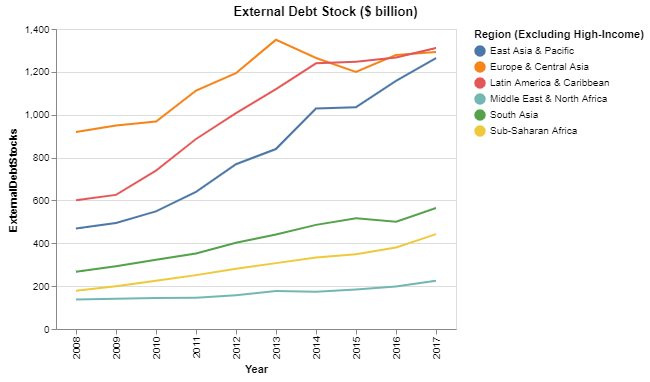

In [12]:
# defining the data source
source = EXDclean

# create the chart
alt.Chart(source,
    # size of the chart
    width=400,
    height=300
).mark_line(
    point="transparent" # this is set to transparent to enhance the tooltip selection
).encode(
    # Select X and Y using the column names
    x="Year",
    y="ExternalDebtStocks",
    # Categorizing data by "region" and adding a legend
    color=alt.Color("Region", legend=alt.Legend(title="Region (Excluding High-Income)")),
    # Adding and formatting the tooltip
    tooltip=[alt.Tooltip("ExternalDebtStocks", format=".0f", title="External Debt Stock ($ bil)"),
            alt.Tooltip("Region"),
            alt.Tooltip("Year")],
).properties(
    #title of chart
    title="External Debt Stock ($ billion)")